# Quick Start Tutorial: Feature Engineering

## Learning Objectives

In this tutorial you will learn:
1. How to create and use views
2. How features, entities, and observation sets are used together
3. How to create a lookup feature
4. How to create an aggregate feature
5. How to save features
6. How to reuse features
7. How to create a feature list
8. How to materialize feature values

## Set up the prerequisites

Learning Objectives

In this section you will:
* start your local featurebyte server
* import libraries
* learn about catalogs
* activate a pre-built catalog

### Load the featurebyte library and connect to the local instance of featurebyte

In [1]:
# library imports
import pandas as pd
import numpy as np

# load the featurebyte SDK
import featurebyte as fb

# start the local server, then wait for it to be healthy before proceeding
fb.playground()

02:14:40 | INFO     | Using configuration file at: /home/chester/.featurebyte/config.yaml
02:14:40 | INFO     | Active profile: local (http://127.0.0.1:8088)
02:14:40 | INFO     | SDK version: 0.2.2
02:14:40 | INFO     | Active catalog: default
02:14:40 | INFO     | 0 feature list, 0 feature deployed
02:14:40 | INFO     | (1/4) Starting featurebyte services
 Container spark-thrift  Running
 Container redis  Running
 Container mongo-rs  Running
 Container featurebyte-worker  Running
 Container featurebyte-server  Running
 Container mongo-rs  Waiting
 Container redis  Waiting
 Container mongo-rs  Waiting
 Container redis  Healthy
 Container mongo-rs  Healthy
 Container mongo-rs  Healthy
02:14:41 | INFO     | (2/4) Creating local spark feature store
02:14:41 | INFO     | (3/4) Import datasets
02:14:42 | INFO     | Dataset grocery already exists, skipping import
02:14:42 | INFO     | Dataset healthcare already exists, skipping import
02:14:42 | INFO     | Dataset creditcard already exists,

### Concept: Catalog

A Catalog object operates as a centralized metadata repository for organizing tables, entities, features, and feature lists and other objects to facilitate feature serving for a specific domain.
By employing a catalog, your team members can share, search, access, and reuse these assets.

### Create a pre-built catalog for this tutorial, with the data, metadata, and features already set up

Note that creating a pre-built catalog is not a step you will do in real-life. This is a function specific to this quick-start tutorial to quickly skip over many of the preparatory steps and get you to a point where you can materialize features.

In a real-life project you would do data modeling, declaring the tables, entities, and the associated metadata. This would not be a frequent task, but forms the basis for best-practice feature engineering.

In [2]:
# get the functions to create a pre-built catalog
from prebuilt_catalogs import *

# create a new catalog for this tutorial
catalog = create_tutorial_catalog(PrebuiltCatalog.QuickStartFeatureEngineeering)

Cleaning up existing tutorial catalogs


02:14:43 | INFO     | Catalog activated: quick start feature engineering 20230511:0214


Building a quick start catalog for feature engineering named [quick start feature engineering 20230511:0214]
Creating new catalog
Catalog created
Registering the source tables
Registering the entities
Tagging the entities to columns in the data tables
Populating the feature store with example features
Catalog created and pre-populated with data and features


## Create Views of Tables within the Catalog

Learning Objectives

In this section you will learn:
* about tables and table types
* about the dataset used in this tutorial
* how to load tables
* about views
* how to create views

### Concept: Catalog table

A Catalog Table provides a centralized location for metadata about a source table. This metadata determines the type of operations that can be applied to the table's views and includes essential information for feature engineering.

### Concept: Table types

Understanding the type of data contained in a table is crucial because it helps determine the appropriate feature engineering techniques that can be applied to the table.

Featurebyte supports four of the most common types of data table.

1. an <b>event</b> table represents a table in the data warehouse where each row indicates a unique business event occurring at a particular time. Event tables can take various forms, such as an Order table in E-commerce, Credit Card Transactions in Banking, Doctor Visits in Healthcare, and Clickstream on the Internet.  
2. An <b>item</b> table represents a table in the data warehouse containing detailed information about a specific business event. For instance, an Item table can contain information about Product Items purchased in Customer Orders or Drug Prescriptions issued during Doctor Visits by Patients.
3. A <b>dimension</b> table represents a table in the data warehouse containing static descriptive data. Using a Dimension table requires special attention. If the data in the table changes slowly, it is not advisable to use it because these changes can cause significant data leaks during model training and adversely affect the inference performance. In such cases, it is recommended to use a Slowly Changing Dimension table of Type 2 that maintains a history of changes. For example, dimension data could contain the product group of each grocery product.
4. A <b>slowly changing dimension</b> (SCD) table represents a table in a data warehouse that contains data that changes slowly and unpredictably over time. There are two main types of SCDs: Type 1, which overwrites old data with new data, and Type 2, which maintains a history of changes by creating a new record for each change. FeatureByte only supports the use of Type 2 SCDs since SCDs of Type 1 may cause data leaks during model training and poor performance during inference. An SCD Table of Type 2 utilizes a natural key to distinguish each active row and facilitate tracking of changes over time. The SCD table employs effective and expiration date columns to determine the active status of a row. In certain instances, an active flag column may replace the expiration date column to indicate if a row is currently active. For example, slowly changing dimension data could contain customer data, which has attributes that need versioning, such as when a customer changes address.

### Introduction to the French grocery dataset

This tutorial uses the French grocery dataset that has been pre-installed in quick-start feature engineering catalog. It consists of 4 data tables recording grocery purchasing activity for each customer.<br>

1. <b>GroceryCustomer</b> is a slowly changing dimension table containing customer attributes.
2. <b>GroceryInvoice</b> is an event table containing grocery purchase transactions.
3. <b>InvoiceItems</b> is an event items table containing details of the basket of grocery items purchased in each transaction.
4. <b>GroceryProduct</b> is a dimension table containing the product attributes for each grocery item being sold.

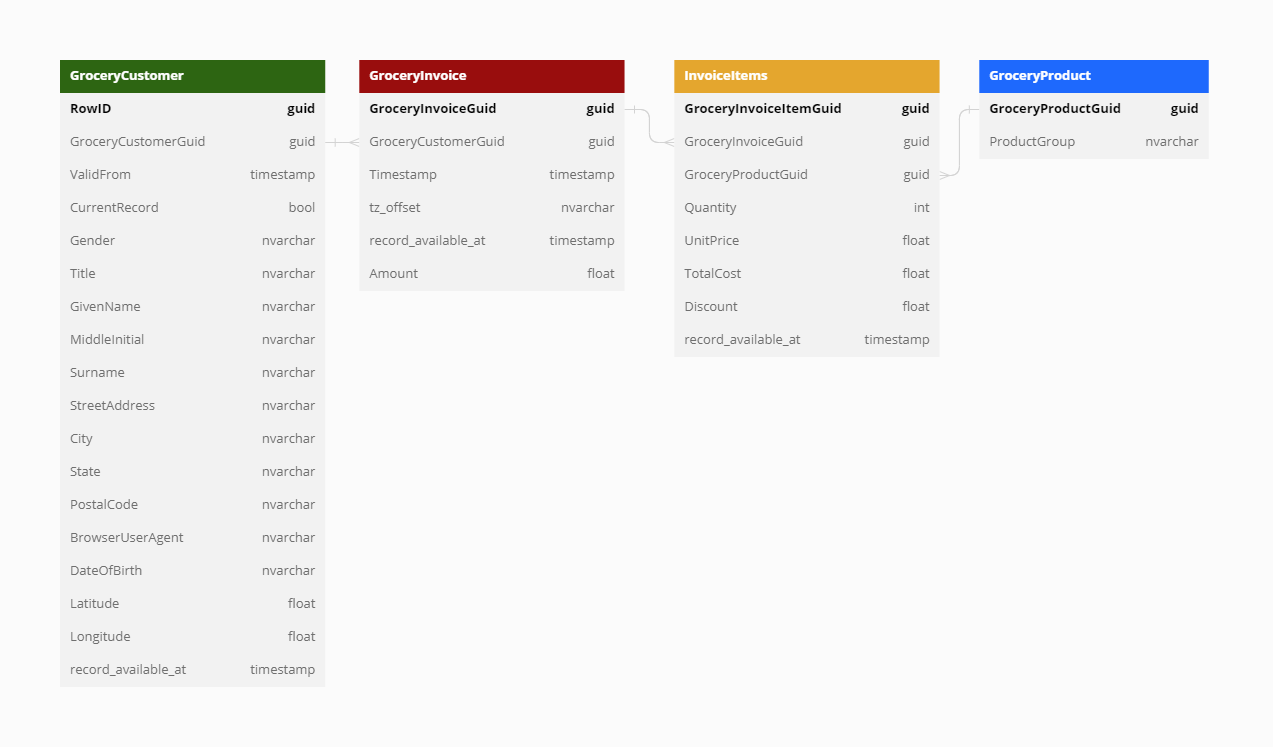

### Example: Load featurebyte tables

FeatureByte works on the principle of not moving data unnecessarily. So when you load a featurebyte table, you load its metadata, not the full contents of the table.

In [3]:
# get the tables for this catalog
grocery_customer_table = catalog.get_table("GROCERYCUSTOMER")
grocery_items_table = catalog.get_table("INVOICEITEMS")
grocery_invoice_table = catalog.get_table("GROCERYINVOICE")

### Concept: FeatureByte view

A FeatureByte view is a local virtual table that can be modified and joined to other views to prepare data before feature definition. A view does not contain any data of its own, but instead retrieves data from the underlying tables each time it is queried. It doesn't modify the data in those tables either. The view object works similar to a SQL view.

### Example: Syntax for creating views

In [4]:
# create views from the tables
grocery_customer_view = grocery_customer_table.get_view()
grocery_invoice_view = grocery_invoice_table.get_view()
grocery_items_view = grocery_items_table.get_view()

## Features

Learning Objectives

In this section you will learn:
* the definition of a feature
* about entities and primary entities
* how to list entities
* what is an observation set, and how to create one

### Concept: Feature

A Feature object contains the logical plan to compute a feature which is usually used as input data to train or predict Machine Learning models.

There are three ways to define the plan for Feature objects from views: either as a Lookup feature, as an Aggregate feature or as a Cross Aggregate feature.

Additionally, Feature objects can be created as transformations of one or more existing features.

### Concept: Entity

An Entity object contains metadata on a real-world object or concept represented or referenced by tables within your data warehouse.

Entities facilitate automatic table join definitions, serve as the unit of analysis for feature engineering, and aid in organizing features, feature lists, and use cases.

All features must relate to an entity (or entities) as their primary unit of analysis.

### Concept: Feature Primary Entity
The primary entity of a feature defines the level of analysis for that feature.

The primary entity is usually a single entity. However, in some instances, it may be a tuple of entities.

When a feature is a result of an aggregation grouped by multiple entities, the primary entity is a tuple of those entities. For instance, if a feature quantifies the interaction between a customer entity and a merchant entity in the past, such as the sum of transaction amounts grouped by customer and merchant in the past 4 weeks, the primary entity is the tuple of customer and merchant.

When a feature is derived from features with different primary entities, the primary entity is determined by the entity relationships. The lowest level entity in the hierarchy is selected as the primary entity. If the entities have no relationship, the primary entity becomes a tuple of those entities.

For example, if a feature compares the basket of a customer with the average basket of customers in the same city, the primary entity is the customer since the customer entity is a child of the customer city entity. However, if the feature is the distance between the customer location and the merchant location, the primary entity becomes the tuple of customer and merchant since these entities do not have any parent-child relationship.

### Example: List entities

Note that in this case study, all entities except French state are used for joining tables. 

All entities can be used as a unit of analysis for features. For example, the French state entity can be used for creating features that aggregate over the geography.

In [5]:
# list the entities in the dataset
catalog.list_entities()

,id,name,serving_names,created_at
0,645c4f9e1799f9191001536f,frenchstate,[FRENCHSTATE],2023-05-11 02:14:54.367
1,645c4f9e1799f9191001536e,groceryproduct,[GROCERYPRODUCTGUID],2023-05-11 02:14:54.303
2,645c4f9e1799f9191001536d,groceryinvoice,[GROCERYINVOICEGUID],2023-05-11 02:14:54.238
3,645c4f9e1799f9191001536c,grocerycustomer,[GROCERYCUSTOMERGUID],2023-05-11 02:14:54.176


### Concept: Observation set

An observation set combines entity key values and historical points-in-time, for which you wish to materialize feature values.

The observation set can be a Pandas DataFrame or an ObservationTable object representing an observation set in the feature store.

### Example: Creating an observation set

Some use cases are about events, and require predictions to be triggered when a specified event occurs.

For a use case requiring predictions about a grocery customer whenever an invoice event occurs, your observation set may be sampled from historical invoices.

In [6]:
# get some invoice IDs and invoice event timestamps from 2022
filter = grocery_invoice_view["Timestamp"].dt.year == 2022
observation_set = (
    grocery_invoice_view[filter]
    .sample(5)[["GroceryCustomerGuid", "Timestamp"]]
    .rename(
        {
            "Timestamp": "POINT_IN_TIME",
            "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
        },
        axis=1,
    )
)
display(observation_set)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,d2fc87d2-3584-4c8f-9359-b3ff10b5dc09,2022-12-26 16:29:21
1,c22fa3eb-55a5-4a4f-9301-38f6b6f0567e,2022-06-23 18:24:52
2,e034e01c-50de-42f0-a879-82c093af5f49,2022-12-19 15:49:29
3,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-02-13 16:52:33
4,38244c7f-6cc5-42fb-a959-5877bb217455,2022-10-26 17:18:43


## Create a Lookup Feature

Learning Objectives

In this section you will learn:
* how to transform data
* what is a lookup feature
* how to create a lookup feature

### Concept: View Column Transforms

View Column Transforms refer to the ability to apply transformation operations on columns within a view. These operations generate a new column that can either be assigned back to the view or used for subsequent transformations.

The different types of transforms include generic transforms, numeric transforms, string transforms, datetime transforms, and lag transforms.

### Example: Transforming data in a view

In [7]:
# extract the operating system from the BrowserUserAgent column
grocery_customer_view["OperatingSystem"] = "Unknown"
filter1 = grocery_customer_view.BrowserUserAgent.str.contains("Windows")
filter2 = grocery_customer_view.BrowserUserAgent.str.contains("Mac OS X")
grocery_customer_view.OperatingSystem[filter1] = "Windows"
grocery_customer_view.OperatingSystem[filter2] = "Mac"

# display a sample of the results
display(
    grocery_customer_view[["GroceryCustomerGuid", "BrowserUserAgent", "OperatingSystem"]].sample()
)

,GroceryCustomerGuid,ValidFrom,BrowserUserAgent,OperatingSystem
0,a8cd7041-3f41-4a6b-9745-798e2300a717,2019-01-10 09:06:37,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows
1,bbaff8e5-44ab-4f61-a4e6-405f274bf429,2022-07-03 16:01:40,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows
2,9359ef7b-7fd8-4587-bc40-e89f6acc1218,2019-01-09 20:44:25,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,Mac
3,7ce7bcc5-9ded-4f9a-bd9a-5f85f8ea6cca,2020-10-16 11:39:05,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,Windows
4,fb39edea-9527-4a9b-a4f5-f9cf697a124f,2019-01-01 13:53:50,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5...,Mac
5,f15331f3-52ad-4f2a-acc2-bd71900823a7,2019-01-01 13:50:34,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows
6,9e88c6d9-7c42-4a00-96b0-0012d79a1e15,2019-01-05 17:46:28,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,Windows
7,dd1dcef9-26b3-4de6-95b0-36410c1ecf98,2022-05-10 10:16:54,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows
8,c87f9847-fa5a-4dd8-a62a-40565c8996d0,2019-01-15 13:19:54,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,Mac
9,db726554-ea0d-422d-b4de-39efa949f60c,2019-01-03 17:00:37,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,Windows


### Concept: Natural key

A Natural Key is a generally accepted identifier used to identify real-world objects uniquely. In a Slowly Changing Dimension (SCD) table, a natural key (also called alternate key) is a column or a group of columns that remain constant over time and uniquely identifies each active row in the table at any point-in-time.

This key is crucial in maintaining and analyzing the historical changes made in the table.

For example, consider a SCD table providing changing information on customers, such as their addresses. The customer ID column of this table can be considered a natural key since it remains constant and uniquely identifies each customer. A given customer ID is associated with at most one address at a particular point-in-time, while over time, multiple addresses can be associated with a given customer ID.

### Concept: Lookup feature

A Lookup feature refers to an entity’s attribute in a View at a specific point-in-time. Lookup features do not involve any aggregation processes.

When a FeatureByte view's primary key identifies an entity, it is simple to designate its attributes as features for that particular entity. Examples of Lookup features are a customer's birthplace retrieved from a Customer Dimension table or a transaction amount retrieved from a Transactions Event table.

In situations where an entity serves as the natural key of an SCD view, it is also possible to assign one of its attributes as a feature for that entity. However, in those cases, the feature is materialized through point-in-time joins, and the resulting value corresponds to the active row at the specified point-in-time of the feature request. For instance, a customer feature could be the customer's street address at the request's point-in-time.

When dealing with an SCD view, you can specify an offset if you want to get the feature value at a specific time before the request's point-in-time. For example, by setting the offset to 9 weeks, the feature would represent the customer's street address 9 weeks before the request's point-in-time.

### Example: Syntax for declaring a lookup feature

In [8]:
# create a feature from the operating system column
customer_operating_system = grocery_customer_view.OperatingSystem.as_feature("OperatingSystem")

# create a multi-row preview of the feature values
display(customer_operating_system.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,OperatingSystem
0,d2fc87d2-3584-4c8f-9359-b3ff10b5dc09,2022-12-26 16:29:21,Mac
1,c22fa3eb-55a5-4a4f-9301-38f6b6f0567e,2022-06-23 18:24:52,Windows
2,e034e01c-50de-42f0-a879-82c093af5f49,2022-12-19 15:49:29,Windows
3,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-02-13 16:52:33,Unknown
4,38244c7f-6cc5-42fb-a959-5877bb217455,2022-10-26 17:18:43,Windows


## Create an Aggregate Feature

Learning Objectives

In this section you will learn:
* what is an aggregate feature
* how to create a aggregate feature over a time window

### Concept: Aggregate feature

Aggregate Features are an important type of feature engineering that involves applying various aggregation functions to a collection of data points grouped by an entity (or a tuple of entities). Supported aggregation functions include the latest, count, sum, average, minimum, maximum, and standard deviation. It is important to consider the temporal aspect when conducting these aggregation operations.

There are three main types of aggregate features, including simple aggregates, aggregates over a window, and aggregates "as at" a point-in-time.

If a feature is intended to capture patterns of interaction between two or more entities, these aggregations are grouped by the tuple of the entities. For instance, an aggregate feature can be created to show the amount spent by a customer with a merchant in the recent past.

### Concept: Aggregates over a window

Aggregates over a window refer to features that are generated by aggregating data within a specific time frame. These types of features are commonly used for analyzing event and item data.

### Example: Syntax for creating an aggregate feature over a window

In [9]:
# calculate the percentage discount for each grocery item
grocery_items_view["PercentageDiscount"] = (
    grocery_items_view.Discount
    / (grocery_items_view.TotalCost + grocery_items_view.Discount)
    * 100.0
)

# display a sample of the results
display(
    grocery_items_view.sample()[
        ["GroceryCustomerGuid", "Discount", "TotalCost", "PercentageDiscount"]
    ]
)

,GroceryCustomerGuid,Discount,TotalCost,PercentageDiscount
0,c6ef9073-3351-4f54-869a-4c926a479520,0.18,1.74,9.375000
1,09fbee0c-521e-40ee-a2ff-8ed4187dcbc4,0.39,2.50,13.494810
2,53cfd09f-9293-4d66-b876-0087e3a5f35b,0.00,0.75,0.000000
3,86a8a582-9cb8-4850-9de8-8e064f2111f2,0.00,1.98,0.000000
4,9c23c4e8-f0e8-4aa4-83e9-3d3525461a8f,0.00,1.29,0.000000
5,3cc23dcd-7238-4a92-bb01-61126d9ff825,0.05,1.00,4.761905
6,12c2d702-1b92-4375-8fd4-5b3bd18f7d87,0.00,8.99,0.000000
7,2328730d-9979-45de-8511-117697556fbc,2.09,2.50,45.533769
8,b21ae11c-83cf-4146-832e-1163413a3295,0.10,1.19,7.751938
9,db2d5721-8869-40f7-984c-a94d614fdf69,0.00,0.25,0.000000


In [10]:
# get the maximum percentage discount on a grocery item for each customer over 90 days and 180 days,
# grouped by customer
customer_max_percent_discount = grocery_items_view.groupby("GroceryCustomerGuid").aggregate_over(
    "PercentageDiscount",
    method=fb.AggFunc.MAX,
    feature_names=["MaxDiscount_30days", "MaxDiscount_90days"],
    fill_value=0,
    windows=["30d", "90d"],
)

# create a multi-row preview of the feature values
display(customer_max_percent_discount.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,MaxDiscount_30days,MaxDiscount_90days
0,d2fc87d2-3584-4c8f-9359-b3ff10b5dc09,2022-12-26 16:29:21,0.000000,32.432432
1,c22fa3eb-55a5-4a4f-9301-38f6b6f0567e,2022-06-23 18:24:52,61.240310,61.240310
2,e034e01c-50de-42f0-a879-82c093af5f49,2022-12-19 15:49:29,48.586118,55.183946
3,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-02-13 16:52:33,61.389961,61.389961
4,38244c7f-6cc5-42fb-a959-5877bb217455,2022-10-26 17:18:43,41.860465,41.860465


## Save features

Learning Objectives

In this section you will learn:
* how to save features

### Example: Saving features to the Catalog

In [11]:
# save features to the Catalog
customer_operating_system.save()
customer_max_percent_discount.save()

## Reuse an Existing Feature

Learning Objectives

In this section you will learn:
* how to load a feature from the catalog
* how to view the feature lineage

### Example: Reuse an existing feature

In [12]:
# show the existing features
existing_features = catalog.list_features()

display(existing_features)

,id,name,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
0,645c4fb21799f9191001537f,MaxDiscount_90days,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:15:22.354
1,645c4fb11799f9191001537b,MaxDiscount_30days,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:15:20.623
2,645c4fac1799f91910015378,OperatingSystem,VARCHAR,DRAFT,False,[GROCERYCUSTOMER],[GROCERYCUSTOMER],[grocerycustomer],[grocerycustomer],2023-05-11 02:15:18.949
3,645c4fa21799f91910015376,CustomerPurchasedItemsEntropy_28d,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-11 02:14:59.658
4,645c4fa21799f91910015370,CustomerInvoiceCount_60days,FLOAT,DRAFT,False,[GROCERYINVOICE],[GROCERYINVOICE],[grocerycustomer],[grocerycustomer],2023-05-11 02:14:58.445


In [13]:
# load a feature from the Catalog
customer_purchased_items_entropy_28days = catalog.get_feature("CustomerPurchasedItemsEntropy_28d")

# create a multi-row preview of the feature values
display(customer_purchased_items_entropy_28days.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerPurchasedItemsEntropy_28d
0,d2fc87d2-3584-4c8f-9359-b3ff10b5dc09,2022-12-26 16:29:21,0.693147
1,c22fa3eb-55a5-4a4f-9301-38f6b6f0567e,2022-06-23 18:24:52,4.514529
2,e034e01c-50de-42f0-a879-82c093af5f49,2022-12-19 15:49:29,2.197225
3,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-02-13 16:52:33,4.135951
4,38244c7f-6cc5-42fb-a959-5877bb217455,2022-10-26 17:18:43,3.485587


### Concept: Feature Definition File

The feature definition file is the single source of truth for a feature version. This file is automatically generated when a feature is declared in the SDK or a new version is derived.

The syntax used in the SDK is also used in the feature definition file. The file provides an explicit outline of the intended operations of the feature declaration, including those inherited but not explicitly declared by you. For example, these operations may include feature job settings and cleaning operations inherited from tables metadata.

The feature definition file is the basis for generating the final logical execution graph, which is then transpiled into platform-specific SQL (e.g. SnowSQL, SparkSQL) for feature materialization.

### Example: Show Feature Definition File

In [14]:
# display the feature lineage for the feature we just loaded from the Catalog
display(customer_purchased_items_entropy_28days.definition)

'# Generated by SDK version: 0.2.2\nfrom bson import ObjectId\nfrom featurebyte import FeatureJobSetting\nfrom featurebyte import ItemTable\n\n\n# item_table name: "INVOICEITEMS", event_table name: "GROCERYINVOICE"\nitem_table = ItemTable.get_by_id(ObjectId("645c4f991799f9191001536a"))\nitem_view = item_table.get_view(\n    event_suffix=None,\n    view_mode="manual",\n    drop_column_names=[],\n    column_cleaning_operations=[],\n    event_drop_column_names=["record_available_at"],\n    event_column_cleaning_operations=[],\n    event_join_column_names=[\n        "Timestamp",\n        "GroceryInvoiceGuid",\n        "GroceryCustomerGuid",\n        "tz_offset",\n    ],\n)\ngrouped = item_view.groupby(\n    by_keys=["GroceryCustomerGuid"], category="GroceryProductGuid"\n).aggregate_over(\n    value_column=None,\n    method="count",\n    windows=["28d"],\n    feature_names=["CustomerInventory_28d"],\n    feature_job_setting=FeatureJobSetting(\n        blind_spot="0s", frequency="3600s", time_modulo_frequency="90s"\n    ),\n    skip_fill_na=True,\n)\nfeat = grouped["CustomerInventory_28d"]\nfeat_1 = feat.cd.entropy()\nfeat_1.name = "CustomerPurchasedItemsEntropy_28d"\noutput = feat_1\n'

## Create a Feature List

Learning Objectives

In this section you will learn:
* how to create a feature list
* how to save a feature list

### Concept: Feature list

A FeatureList object is a collection of Feature objects that is tailored to meet the needs of a particular use case. It is commonly used in generating feature values for Machine Learning training and inference.

The primary entity of a feature list determines the entities that can be used to serve the feature list, which typically corresponds to the primary entity of the Use Case that the feature list was created for. Nevertheless, if there is a mismatch, the serving entities of the Feature List are utilized to evaluate its compatibility with the Use Case.

### Example: Create a feature list

In [15]:
# feature list can be constructed from both features and feature groups
grocery_features = fb.FeatureList(
    [
        customer_operating_system,
        customer_max_percent_discount,
        customer_purchased_items_entropy_28days,
    ],
    name="quick_start_grocery_features",
)

# materialize the feature values for this feature list
display(grocery_features.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,OperatingSystem,MaxDiscount_30days,MaxDiscount_90days,CustomerPurchasedItemsEntropy_28d
0,d2fc87d2-3584-4c8f-9359-b3ff10b5dc09,2022-12-26 16:29:21,Mac,0.000000,32.432432,0.693147
1,c22fa3eb-55a5-4a4f-9301-38f6b6f0567e,2022-06-23 18:24:52,Windows,61.240310,61.240310,4.514529
2,e034e01c-50de-42f0-a879-82c093af5f49,2022-12-19 15:49:29,Windows,48.586118,55.183946,2.197225
3,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-02-13 16:52:33,Unknown,61.389961,61.389961,4.135951
4,38244c7f-6cc5-42fb-a959-5877bb217455,2022-10-26 17:18:43,Windows,41.860465,41.860465,3.485587


### Example: Save a feature list

In [16]:
# save the feature list to the Catalog
grocery_features.save()

display(catalog.list_feature_lists())

Saving Feature(s) |████████████████████████████████████████| 4/4 [100%] in 2.7s 
Loading Feature(s) |████████████████████████████████████████| 4/4 [100%] in 1.3s


,id,name,num_feature,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,645c4fc01799f91910015384,quick_start_grocery_features,4,DRAFT,False,0.0,0.0,"[GROCERYCUSTOMER, GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-05-11 02:15:38.523


In [17]:
# show the feature list in the Catalog

# get all feature lists
all_feature_lists = catalog.list_feature_lists()

# display the metadata for the feature list we just saved
# display only the matching feature list
display(all_feature_lists[all_feature_lists.name == grocery_features.name])

,id,name,num_feature,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,645c4fc01799f91910015384,quick_start_grocery_features,4,DRAFT,False,0.0,0.0,"[GROCERYCUSTOMER, GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-05-11 02:15:38.523


## Materialize Feature Values

Learning Objectives

In this section you will learn:
* how to get historical values for a feature list
* how to deploy a feature list
* how to consume features via the API
* how to disable a deployed feature list

### Example: Get historical features

While the preview function materializes feature values when prototyping, the scalable approach to materialize features for training data is to use the get_historical_features function, which accesses cached feature values from the feature store.

In [18]:
# materialize the values
historical_data = grocery_features.compute_historical_features(observation_set)

# display the historical data
display(historical_data)

Retrieving Historical Feature(s) |████████████████████████████████████████| 1/1 


,GROCERYCUSTOMERGUID,POINT_IN_TIME,MaxDiscount_90days,MaxDiscount_30days,OperatingSystem,CustomerPurchasedItemsEntropy_28d
0,d2fc87d2-3584-4c8f-9359-b3ff10b5dc09,2022-12-26 16:29:21,32.432432,-0.000000,Mac,0.693147
1,c22fa3eb-55a5-4a4f-9301-38f6b6f0567e,2022-06-23 18:24:52,61.240310,61.240310,Windows,4.514529
2,e034e01c-50de-42f0-a879-82c093af5f49,2022-12-19 15:49:29,55.183946,48.586118,Windows,2.197225
3,7a1bc5dc-e198-419e-b972-0abbdf8903c1,2022-02-13 16:52:33,61.389961,61.389961,Unknown,4.135951
4,38244c7f-6cc5-42fb-a959-5877bb217455,2022-10-26 17:18:43,41.860465,41.860465,Windows,3.485587


### Example: Deploy a feature list

A Feature List is deployed to support online serving. This triggers the orchestration of the feature materialization into the online feature store

In [19]:
# deploy the new feature list, setting all the features to be production ready
deployment = grocery_features.deploy(make_production_ready=True)
deployment.enable()

Loading Feature(s) |████████████████████████████████████████| 4/4 [100%] in 1.3s
Done! |████████████████████████████████████████| 100% in 6.0s (0.17%/s)         
Done! |████████████████████████████████████████| 100% in 1:30.5 (0.01%/s)       


### Example: Consume features via API

Once a feature list has been deployed, you can consume it via the feature serving API.

You can either use a python template or a shell script where the generated code will use the curl command to send the request.

For the python template, set the language parameter value as 'python'.
For the shell script, set the language parameter value as 'sh'.

In [20]:
# get a python template for consuming the feature serving API
deployment.get_online_serving_code(language="python")

Loading Feature(s) |████████████████████████████████████████| 4/4 [100%] in 1.3s


'from typing import Any, Dict\n\nimport pandas as pd\nimport requests\n\n\ndef request_features(entity_serving_names: Dict[str, Any]) -> pd.DataFrame:\n    """\n    Send POST request to online serving endpoint\n\n    Parameters\n    ----------\n    entity_serving_names: Dict[str, Any]\n        Entity serving name values to used for serving request\n\n    Returns\n    -------\n    pd.DataFrame\n    """\n    response = requests.post(\n        url="http://127.0.0.1:8088/deployment/645c4fe91799f91910015388/online_features",\n        headers={"Content-Type": "application/json", "active-catalog-id": "645c4f931799f91910015367"},\n        json={"entity_serving_names": entity_serving_names},\n    )\n    assert response.status_code == 200, response.json()\n    return pd.DataFrame.from_dict(response.json()["features"])\n\n\nrequest_features([{"GROCERYCUSTOMERGUID": "0041bdff-4917-42d5-bd6d-5a555ac616c5"}])'

Paste the output from the previous notebook cell into the following Python cell and run it. Note that in production there is no historical point_in_time parameter for materializing features.

In [21]:
# paste generated Python code here

### Example: Disable a deployment

In [22]:
# disable the feature list deployment
deployment.disable()

# show the deployed feature lists
feature_lists = catalog.list_feature_lists()
feature_lists = feature_lists[feature_lists.deployed == True]
display(feature_lists)

Done! |████████████████████████████████████████| 100% in 21.1s (0.05%/s)        


,id,name,num_feature,status,deployed,readiness_frac,online_frac,tables,entities,created_at


## Next Steps

Now that you've completed the quick-start feature engineering tutorial, you can put your knowledge into practice or learn more:<br>
1. Put your knowledge into practice by creating features in the "credit card dataset feature engineering playground" or "healthcare dataset feature engineering playground" catalogs
2. Learn more about feature engineering via the "Deep Dive Feature Engineering" tutorial
3. Learn about data modeling via the "Deep Dive Data Modeling" tutorial